##### Deber Simpy - Parte 1
<h1><center>Entornos de soporte al desarrollo de simulaciones: Simpy - Parte 1</center></h1>
<h2><center> Universidad "Politecnica Salesiana" </center></h2>
<h5><right>Alumno: Juan Cañar. <br> Docente: Ing. Diego Quisi. </right></h5>

----
## 1. Instalación de Simpy
Existen diversas alternativas para instalar **simpy** (no confundir con _sympy_), sin embargo, en esta subsección mostraremos cómo hacerlo.


### 1.1. Pasos a seguir:
En virtud de que **simpy** requiere la versión 3.7 de Python, llevaremos a cabo el proceso para instalar dicha versión:
1. Creamos el entorno virtual llamado "simulacion" con la versión 3.7 de Python:

        conda activate
        
2. Installamos **simpy**  en el entorno creado:
        pip3 install -U simpy
        


Si la instalación ha sido exitosa, podremos ejecutar el siguiente código sin inconvenientes:

In [2]:
import simpy

# Definimos un reloj:
def reloj(env, nombre, tiempo):
    while True:
        print(nombre,">",env.now) 
        yield env.timeout(tiempo) # Pasamos el control al programa principal
        
env=simpy.Environment() # Creamos un entorno de simulación
env.process(reloj(env, 'R. Rapido',0.25)) # Ejecutamos un "reloj" rapido (timer) en el entorno con el tiempo especificado
env.process(reloj(env, 'R. Lento',0.5)) # Ejecutamos un "reloj" lento (timer) en el entorno con el tiempo especificado

env.run(until=2.1) # Ejecutamos los procesos 2 unidades de tiempo

R. Rapido > 0
R. Lento > 0
R. Rapido > 0.25
R. Lento > 0.5
R. Rapido > 0.5
R. Rapido > 0.75
R. Lento > 1.0
R. Rapido > 1.0
R. Rapido > 1.25
R. Lento > 1.5
R. Rapido > 1.5
R. Rapido > 1.75
R. Lento > 2.0
R. Rapido > 2.0


## 2. Ejemplo del negocio de lavado de autos [5]

Este ejemplo permite simular un negocio de lavado de automóviles. De igual forma, es importante destacar que este ejemplo aborda los siguientes puntos:

* Estados de espera por otros procesos
* Recursos: clase **Resource**


### 2.1. Características del sistema real a simular

Es importante observar que el negocio de lavado de autos tiene características propias a su naturaleza. A continuación establecemos dichas peculiaridades a tener en mente en el momento de llevar a cabo la simulación:

* El negocio tiene un número limitado de máquinas de lavado.
* Se puede recibir un cierto número de vehículos para ser lavados, de los cuáles los que no estén siendo procesados tendrán que esperar.
* Una vez que un vehículo entra a la máquina, debe ser lavado y solo al finalizar la limpieza podrá salir de la misma, dejando un espacio libre a otro vehículo.

### 2.2. Desarrollo de la simulación

A continuación procedemos a desarrollar la simulación.

Como primer paso, importamos las librerías necesarias y establecemos los parámetros requeridos:
* Variables de interés
* Tiempo de simulación
* Parámetros de inicialización (número de máquinas, tiempo de lavado, intervalo de llegada de vehículos).

In [3]:
import simpy
import random

# Maximo de vehiculos que puede recibir el negocio
MAX_VEHICULOS = 57
# Total de maquinas de lavado con que cuenta el negocio
NUM_MAQUINAS = 3
# Tiempo que tarda en lavarse un vehiculo (minutos)
TIEMPO_LAVADO = 7
# Intervalo de tiempo en que llegan vehiculos (minutos)
INTERVALO_LLEGADA = 9
# Tiempo de simulación
TIEMPO_SIMULACION = 23

class Lavanderia(object):
    
    def __init__(self, environment, num_maquinas, tiempo_lavado):
        # Guardamos como variable el entorno de ejecucion
        self.env=environment
        # Creamos el recurso que representa las maquinas
        self.maquinas = simpy.Resource(environment, num_maquinas)
        # Variable para el tiempo de lavado
        self.tiempo_lavado = tiempo_lavado
        
    def lavar_vehiculo(self, vehiculo):
        # Este metodo representa el proceso de lavado del vehículo.
        # Se ingresa el vehículo y se lava
        
        # Simulamos el tiempo que tarda en lavarse el vehiculo
        # Es importante notar que la instruccion "yield" es distinta de "sleep"
        # ya que esta ultima bloquea el hilo de ejecucion durante 't' unidades de tiempo,
        # mientras que 'yield' no bloquea el hilo de ejecucion, solo lo suspende mientras
        # el evento de 'lavado' se realice
        yield self.env.timeout(TIEMPO_LAVADO)
        
        # Simulamos que se ha limpiado parte (%) de la suciedad del vehiculo
        # Para el % generamos un entero entre 30 y 90
        print('Removido  {%d%%} suciedad vehiculo => %s ' \
              % (random.randint(30,90), vehiculo))
        
    
def llegada_vehiculo(env, nombre, lavanderia):
    # Usamos el reloj de la simulacion (env.now()) para indicar a la
    # hora que llega el vehiculo con el nombre pasado como parametro
    print('Llega vehiculo: %s a la hora %.2f.' % (nombre, env.now))
    
    # Especificamos que vamos a usar un recurso (Resource) que representa
    # la maquina de lavado
    with lavanderia.maquinas.request() as maquina:
        # Ocupamos la maquina de lavado
        yield maquina
        # Indicamos que vehiculo entra a la lavanderia
        print('Entra vehiculo a lavarse: %s a la hora %.2f.' % (nombre, env.now))
        # Procesamos la operacion de lavado
        yield env.process(lavanderia.lavar_vehiculo(nombre))
        # Una vez que termina la llamada con 'yield', se indica que se ha lavado el vehiculo
        print('Vehiculo [%s] lavado a las %.2f.' % (nombre, env.now))
    
    
def ejecutar_simulacion(env, num_maquinas, tiempo_lavado, intervalo):
    lavanderia=Lavanderia(env, num_maquinas, tiempo_lavado)
    # Creamos 5 llegadas de vehiculos iniciales
    for i in range(5):
        env.process(llegada_vehiculo(env, 'Vehiculo-%d'%(i+1),lavanderia))
    
    # Ejecutamos la simulacion
    while True:
        yield env.timeout(random.randint(intervalo-2, intervalo+2)) # Generar un randomico de 7 - 11 
        i+=1
        # Mientras se lavan los vehiculos generamos mas vehiculos
        env.process(llegada_vehiculo(env,'Vehiculo-%d'%(i+1),lavanderia))

print('Lavanderia UPS')

# Creamos el entorno de simulacion
env=simpy.Environment()
env.process(ejecutar_simulacion(env, NUM_MAQUINAS, TIEMPO_LAVADO, INTERVALO_LLEGADA))

# Ejecutamos el proceso durante el tiempo de simulacion
env.run(until = TIEMPO_SIMULACION)


Lavanderia UPS
Llega vehiculo: Vehiculo-1 a la hora 0.00.
Llega vehiculo: Vehiculo-2 a la hora 0.00.
Llega vehiculo: Vehiculo-3 a la hora 0.00.
Llega vehiculo: Vehiculo-4 a la hora 0.00.
Llega vehiculo: Vehiculo-5 a la hora 0.00.
Entra vehiculo a lavarse: Vehiculo-1 a la hora 0.00.
Entra vehiculo a lavarse: Vehiculo-2 a la hora 0.00.
Entra vehiculo a lavarse: Vehiculo-3 a la hora 0.00.
Llega vehiculo: Vehiculo-6 a la hora 7.00.
Removido  {33%} suciedad vehiculo => Vehiculo-1 
Removido  {89%} suciedad vehiculo => Vehiculo-2 
Removido  {87%} suciedad vehiculo => Vehiculo-3 
Vehiculo [Vehiculo-1] lavado a las 7.00.
Vehiculo [Vehiculo-2] lavado a las 7.00.
Vehiculo [Vehiculo-3] lavado a las 7.00.
Entra vehiculo a lavarse: Vehiculo-4 a la hora 7.00.
Entra vehiculo a lavarse: Vehiculo-5 a la hora 7.00.
Entra vehiculo a lavarse: Vehiculo-6 a la hora 7.00.
Removido  {64%} suciedad vehiculo => Vehiculo-4 
Removido  {57%} suciedad vehiculo => Vehiculo-5 
Removido  {72%} suciedad vehiculo => Vehi

## Práctica  - SimPy 
---
## Albania 
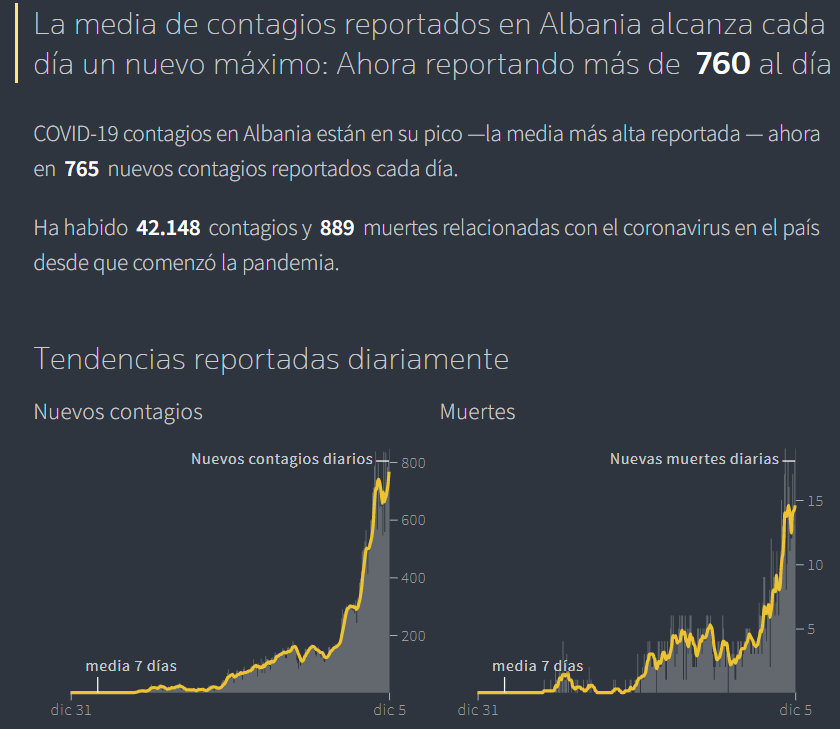
---
https://coronavirus.al/per-qytetaret/
- Investigar el proceso de atencion de un paciente diagnosticado con COVID-19, ademas de tiempos de atencion, recursos necesarios y tipos de pacientes.
---

### - En albania el proceso de atencion de un paciente diagnosticado con COVID-19
- El 25 de febrero, Skender Brataj, jefe del Centro Nacional de Emergencia Médica (NMEC), anunció protocolos en el caso de que la enfermedad de la Covid-19 se expandiera por Albania, explicando que **los ciudadanos que sospechen haber contraído el virus deben contactar con el número de emergencia nacional 127.** 
- Se dieron órdenes para que todos los ciudadanos albaneses que llegaran de China, Singapur, Irán, Corea del Sur o Italia conectaran con el mismo número de teléfono para que un servicio médico pueda acompañarlos a un hospital de infecciones para su examen. El mismo día, el Departamento de Salud y Protección Social se reunió con el Comité de Peritos Técnicos y decidió aumentar su presupuesto hospitalario en 1 millón, para aumentar el stock de equipamientos de protección individual.
- Especificó que los ciudadanos provenientes de las áreas afectadas serían monitorizados durante 14 días y tratados como casos sospechosos.

### Proceso que llevan a cabo:
---
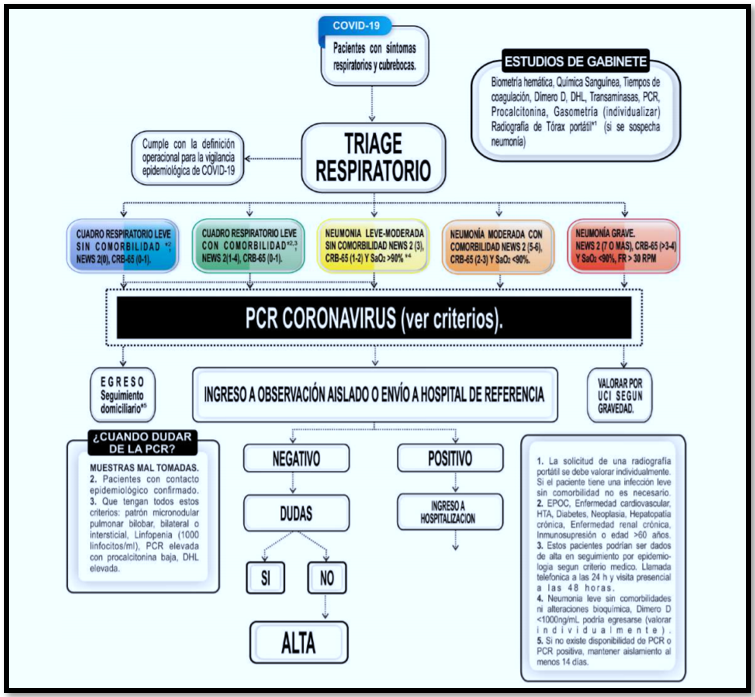

- Investigar en cada una de las provincias asignadas:
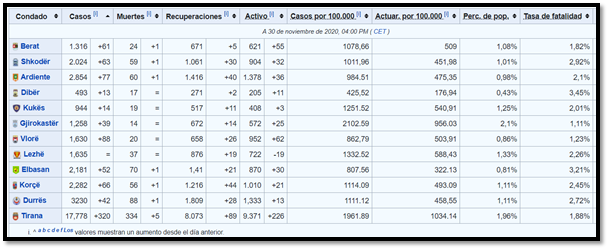

##### Numero de hospitales:

* Los hospitales designados por COVID-19 que están destinados a tratar exclusivamente con pacientes de COVID-19 son:
    - **Servicios de Enfermedades Infecciosas del Centro Hospitalario Universitario "Madre Tereza" (120 camas), denominado Hospital COVID 1.**
    - **Hospital Universitario "Shefqet Ndroqi" ( 193 camas), denominado Hospital COVID 2.**
    
##### Camas:
   - **Ambos poseen un total de camas de 313.**
   - Según el ministro, el hospital COVID-3 abrirá cuando se acaben las capacidades de los otros dos hospitales, mientras que actualmente hay entre 40 y 50 camas disponibles.

   - "Teniendo en cuenta la tendencia en el aumento de casos nuevos, pensamos en abrir el hospital COVID-3 en una semana, mientras que también tenemos el hospital COVID-4 con cerca de 100 camas listas. Los médicos y enfermeras están listos para comenzar en cualquier momento que sea necesario, " ella añadió.
   
##### Respiradores:
   - Teniendo en cuenta que existe un total de 43.890 infectados, existen un total de 45 respiradores en el hospital nuemro 1, en el segundo hospital existe disponibilidad de 30 y 15 se encuentran en uso.
   
##### Personal medico y enfermeria:
   - El personal medico es un poco escaso, debido a que la moyoria de medicos migran a Alemania, Francia o  Italia, lo que le dificulta en esta pandemia tener especialistas, segun datos no oficiales, existen 14 grupos de 10 a 12 medicos en cada hospital
   

##### Limpieza:

   - Para la limpieza poseen un grupo especial de tratamento de desechos, el cual usa trages especiales, y tambien quimicos que ayudan a desinfectar el lugar donde se encuentra los infectados.
       - 9402-14	Hydrogen peroxide; Ammonium carbonate; Ammonium bicarbonate	Hitman Spray	Kimberly-Clark Global Sales LLC	Human coronavirus	5	Ready-to-use	Hard Nonporous (HN)	Institutional; Residential	No
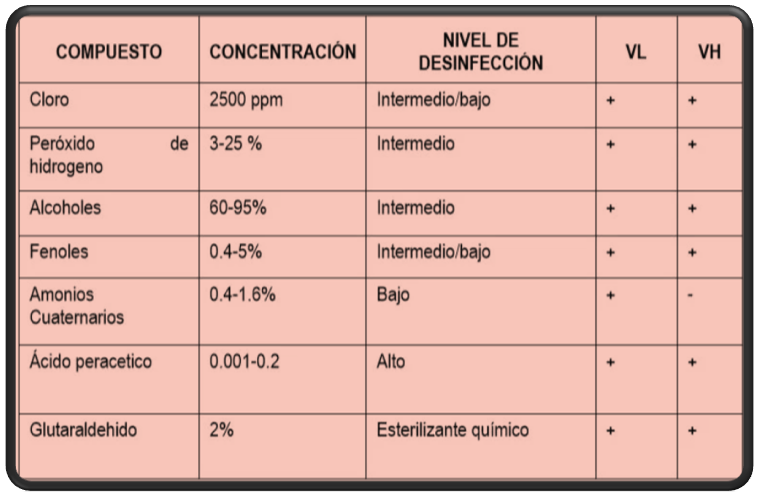

##### Finalmente el costo de atender a un paciente con COVID-19 y medicamentos.
- La mayoría de quienes tienen COVID-19 padecen síntomas leves que pueden tratarse en el hogar con medicamentos de venta libre para bajar la fiebre y reducir la tos. Pero para los casos graves, que son más comunes entre los adultos mayores y las personas con enfermedades preexistentes, se podría necesitar hospitalización.

- Y al igual que los cargos asociados a una cita en el consultorio del médico, el costo de permanecer en el hospital depende del plan de seguro de la persona y los copagos, coseguros y deducibles.

- En un nuevo análisis realizado por Peterson Center on Healthcare y KFF se descubrió que el costo del tratamiento para un caso grave de COVID-19 podría superar (2037000,00 lek) `$` 20.000 USD y que las personas con seguro podrían enfrentar gastos de bolsillo mayores a la cantidad de  (132405,00 lek )   `$` 1,300.
---

## Referencias
[1] Matloff, N. (2008). Introduction to Discrete-Event Simulation and the SimPy Language.

[2] Team Simpy (2017). SimPy Documentation, Release 3.0.10, 2017. URL: https://media.readthedocs.org/pdf/simpy/latest/simpy.pdf

[3] https://www.flasog.org/static/COVID-19/GuiaCOVID19SMME.pdf

[4] http://open.data.al/covid-19/

[5] (https://www.covid19healthsystem.org/countries/albania/livinghit.aspx?Section=3.2%20Managing%20cases&Type=Chapter)

[6] https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Albania